In [1]:
import pandas as pd
import sys
import numpy as np
from matplotlib import pyplot
import h5py
import os
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.metrics import f1_score
import time


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Subset data

Read in data and filter x matrix to only include L1000 and kegg genes

In [2]:
#reading in files
X = pd.read_hdf("data/tcga_mutation_train.h5", "expression")
Y = pd.read_hdf('data/tcga_mutation_train.h5', 'labels')

X_holdout = pd.read_hdf("data/tcga_mutation_test_unlabeled.h5", "expression")
#L1000 subsetting
l1000_file = open("L1000_clueio_genelist.txt")
l1000 = [i.strip() for i in l1000_file.readlines()]
#get l1000 genes that are in data
# L1000_= pd.Series(list(set(X.columns) & set(l1000)))
# X_L1000 = X[L1000_] #subset X data

# Prune expression to only KEGG pathway genes
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    genes_subset = list(set().union(*[line.strip().split("\t")[2:] for line in f.readlines()]))
X_pruned = X.drop(labels=(set(X.columns) - set(genes_subset)), axis=1, errors="ignore")

#using both kegg and L1000
subset_ = set(X_pruned.columns.tolist() + l1000)
subset = pd.Series(list(set(X.columns) & set(subset_)))

print("Number of genes after subsetting:", len(subset))

X_sub = X[subset] #subset X data
X_sub_holdout =X_holdout[subset]


x_array = np.array(X.values, dtype=np.float32)

# extract sample id values
y_names = list(set(Y["detailed_category"].values))
y_names = sorted(y_names)

m,n = X.shape
y_array = np.zeros(shape=(m, len(y_names)+3), dtype=np.float32)

# create a key for id's to indices
y_index_key = {name:i for i,name in enumerate(y_names)}
# generate one-hot vectors for all id's
for m,primary_site_name in enumerate(Y["detailed_category"].values):
    
    index = y_index_key[primary_site_name]
    y_array[m,index] = 1
    
    y_array[m, -3] = Y.iloc[m][6]
    y_array[m, -2] = Y.iloc[m][7]
    y_array[m, -1] = Y.iloc[m][8]
    
    
#split to train + test
xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X_sub, y_array, test_size=0.3, random_state=42)
#split test to test and validate 
xTest, xValidate, yTest, yValidate = sklearn.model_selection.train_test_split(xTest, yTest, test_size=1/3, random_state=42)


print(yTrain)
xTrain = np.array(xTrain.values, dtype=np.float32)
xTest = np.array(xTest.values, dtype=np.float32)

Number of genes after subsetting: 5676
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Define dataset classes

In [3]:
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        x_dtype = torch.FloatTensor

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.x_data[index]

    def __len__(self):
        return self.length
    
class PredictorDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor
        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

## Add noise for denoising autoencoder

For a given gene expression vector, set the expression of 15 genes (about .5% of the genes) to be half the original value

In [4]:

def addNoise(x):
    '''set ~.5% of gene values to 0'''
    length = len(x[0])
    for vector in x:
        for i in range(15):
            i = np.random.randint(0,length)
            vector[i] = vector[i]/2
    return x

### Train

When training the autoencoder, add noise to the input in each epoch

In [5]:

def train_batch(model, x, y, optimizer, loss_fn, layer):
    ''' train one batch. If layer = 0, train entire model. If layer = 1 or 2, train only that layer of the autoencoder'''
    y_predict = model.forward(x, layer)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data[0]


def train(model, x_in, y_in, optimizer, loss_fn, layer, epochs=20, batch_size=16):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        if layer != 0:
            # adding noise to input in each epoch
            x_new = addNoise(x_in)
        else:
            x_new = x_in
        dataset = PredictorDataset(x=x_new, y=y_in)
        loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        for x, y in loader:
            x = Variable(x)
            y = Variable(y)

            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn, layer=layer)
            losses.append(loss)

            batch_index += 1


    return losses



In [6]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x, 0)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        x = Variable(x)
        y = Variable(y)

        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector


## Define the model

A stacked denoising autoencoder. Autoencoder consists of two autoencoder layers and a predictor layer. 

In [7]:
class StackedDenoisingAutoencoder(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self, size1, size2, size3, inputSize, outputSize):
        # Perform initialization of the pytorch superclass
        super(StackedDenoisingAutoencoder, self).__init__()
        learning_rate = 1e-2
        
        # Define network layer dimensions
        D_in, H1, H2, H3, D_out = [inputSize, size1, size2, size3, outputSize]   
        
        self.linear1 = nn.Linear(D_in, H1)
        self.decode1 = nn.Linear(H1, D_in)
        self.linear2 = nn.Linear(H1, H2)
        self.decode2 = nn.Linear(H2, H1)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x, layer):
        '''
        This method defines the network layering and activation functions
        Layer indicates which layers to run: 0 = run entire model, 1 or 2 = run only autoencoding layer 1 or 2
        '''
        if layer == 0:
            x = self.linear1(x) # hidden layer
            x = F.relu(x)       # activation function

            x = self.linear2(x) # output layer
            x = F.relu(x)       # activation function

            x = self.linear3(x) # output layer
            x = F.relu(x)       # activation function

            x = self.linear4(x) # output layer
            
        elif layer == 1:
            
            x = self.linear1(x) # hidden layer
            x = F.relu(x)       # activation function

            x = self.decode1(x) # output layer
            x = F.relu(x)       # activation function
            
        elif layer == 2:
            
            x = self.linear2(x) # hidden layer
            x = F.relu(x)       # activation function

            x = self.decode2(x) # output layer
            x = F.relu(x)       # activation function
            
        return x
    
    
    def encode(self, dataset, layer):
        """Return the encoding"""
        #Get the dataset
        loader = DataLoader(dataset=dataset, batch_size=len(dataset), shuffle=False)
        xs = []
        for x, y in loader:
            x = Variable(x)

            if layer == 0:
                x = self.linear1(x) # hidden layer
                x = F.relu(x)       # activation function

                x = self.linear2(x) # output layer
                x = F.relu(x)       # activation function
                
            elif layer == 1:
                x = self.linear1(x)
                x = F.relu(x)

            xs.append(x.data.numpy())
        encoding = np.concatenate(xs)
        return encoding

## Train on training set and predict on test set

To train the model, the two autoencoding layers are trained separately. The learned weights are then copied into the predicting model which is trained as a feed forward neural net. 

In [20]:
def run():
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 32
    
    dataset_train = PredictorDataset(x=xTrain, y=yTrain)
    dataset_test = PredictorDataset(x=xTest, y=yTest)
    dataset_train_encode = AutoencoderDataset(xTrain)
    
    
    size1, size2 = (int(len(xTest[0])*.75), int(len(xTest[0])/2))
    size3 = size2
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_train_encode = DataLoader(dataset=dataset_train_encode, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-2

    # Define the loss function
    loss_fn = nn.MSELoss()  # mean squared error

    
    
    
    
    ######## Train autoencoder
    startTime = time.time()
    encoder_model = StackedDenoisingAutoencoder(size1, size2, size3,  len(xTest[0]), len(yTest[0]))

    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(encoder_model.parameters(), lr=learning_rate)

    #Train the first autoencoder layer
    train(model=encoder_model, x_in=xTrain, y_in=xTrain, optimizer=optimizer, layer = 1, loss_fn=loss_fn, epochs = 20)

    #Train second autoencoder layer
    x_encoded = np.array(encoder_model.encode(dataset_train, 1))
    train(model=encoder_model, x_in = x_encoded, y_in = x_encoded, optimizer=optimizer, layer = 2, loss_fn=loss_fn, epochs = 20)



    #Create a new neural net for prediction
    #I think pytorch doesn't like training the same model twice so I had to copy the weights into a new model and retrain
    predictor_model = StackedDenoisingAutoencoder(size1, size2, size3, len(xTest[0]), len(yTest[0]))
    #Copy parameters from autoencoding neural net to predicting neural net
    mp = list(encoder_model.parameters())
    mcp = list(predictor_model.parameters())
    for i in range(len(mp)):
        mp[i].data[:] = mcp[i].data[:]

        
        
        
        
        
    #############  Train the predicting model
    optimizer1 = optim.SGD(predictor_model.parameters(), lr=learning_rate) 
    loss = train(model=predictor_model, x_in=xTrain, y_in = yTrain, optimizer=optimizer1, layer = 0, loss_fn=loss_fn, epochs = 50)
    
    
    
    trainTime  = time.time() - startTime
    
    startTime = time.time()
    
    
    
    ############# Test 
    # Test and get the resulting predicted y values
    yPredict = test(model=predictor_model, loader=data_loader_test)

    runTime = time.time() - startTime
    
    #Convert prediction and actual y arrays into array of vectors [tissue, tp53, kras, braf]
    yPred = np.array([[y_names[np.argmax(vector[0:-3])], 1 if vector[-3]>=0.5 else 0, 1 if vector[-2]>=0.5 else 0, 1 if vector[-1]>=0.5 else 0] 
                      for vector in yPredict])

    yActual = np.array([[y_names[np.argmax(vector[0:-3])],1 if vector[-3]==1 else 0, 1 if vector[-2]==1 else 0, 1 if vector[-1]==1 else 0] for vector in yTest])

    isCorrect = [[yPred[i][j] == yActual[i][j] for j in range(len(yPred[0]))] for i in range(len(yPred))]


    numCorrect = np.sum(isCorrect, axis=0)

    pred0, act0 = [v[0] for v in yPred], [v[0] for v in yActual]
    pred1, act1 =  [int(v[1]) for v in yPred], [v[1] for v in yActual]
    pred2, act2 =  [int(v[2]) for v in yPred], [v[2] for v in yActual]
    pred3, act3 =  [int(v[3]) for v in yPred], [v[3] for v in yActual]

    ##### Write output file and get f1 score
    pd.DataFrame({
        "TumorTypePrediction": pred0,
        "TP53MutationPrediction": pred1,
        "KRASMutationPrediction": pred2,
        "BRAFMutationPrediction": pred3,
    }).to_csv("test_predictions.tsv", sep="\t")

    pd.DataFrame({
        "primary.disease.or.tissue": act0,
        "TP53_mutant": act1,
        "KRAS_mutant": act2,
        "BRAF_mutant": act3,
    }).to_csv("test_actuals.tsv", sep="\t")

    print("% Correct with autoencoder: ", size1, size2, size3, (numCorrect/len(isCorrect)))
    print("Train time: %fs  " % trainTime)
    print("Run time: %fs  " % runTime)
    !Rscript class/BME230_F1score_V2.R test_predictions.tsv test_actuals.tsv

    return yPred, yActual, predictor_model


## Plot the f1 score of the mutations by tissue type

In [21]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
def plotByTissue(yPred, yActual):
    
    resultsByTissue = {} #Maps actual tissue to [# total, tp53 tp, tp53 fn,  tp53 fp, p53 tn, kras tp, kras fn, kras fp, kras tn, braf etc...]
    for i in range(len(yPred)):
        tissue = yActual[i][0]
        v = resultsByTissue.get(tissue, ([], []))
        
        pred = [int(yPred[i][1]), int(yPred[i][2]), int(yPred[i][3])]
        act = [int(yPred[i][1]), int(yPred[i][2]), int(yPred[i][3])]
        v[0].append(pred)
        v[1].append(act)
        resultsByTissue[tissue] = v
        
        
        
    fig_width = 5
    fig_height = 2
    plt.figure(figsize = (fig_width, fig_height))

    panel_width = .8*fig_width
    panel_height = .8*fig_height
    panel = plt.axes([0.1,0.1,panel_width, panel_height])
    xLabels = []
    i = 0
    for tissue, v in resultsByTissue.items():
        vals = (np.array(v[0]), np.array(v[1]))
        xLabel = tissue
        xLabels.append(xLabel)
        height1 = f1_score(vals[1][:,0], vals[0][:,0])
        
        height2 = f1_score(vals[1][:,1], vals[0][:,1])
        
        height3 = f1_score(vals[1][:,2], vals[0][:,2])
        
        
        rectangle1 = mplpatches.Rectangle( (i*4, 0), 1, height1, \
                    facecolor = 'red',\
                    edgecolor = 'black')#,linewidth=lineWidth)
        rectangle2 = mplpatches.Rectangle( (i*4+1, 0), 1, height2, \
                    facecolor = 'cyan',\
                    edgecolor = 'black')#,linewidth=lineWidth)
        rectangle3 = mplpatches.Rectangle( (i*4+2, 0), 1, height3, \
                    facecolor = 'green',\
                    edgecolor = 'black')#,linewidth=lineWidth)
        panel.add_patch(rectangle1) 
        panel.add_patch(rectangle2) 
        panel.add_patch(rectangle3)
        i+=1
    
    panel.set_xlim(-1,4*len(resultsByTissue)+1)
    panel.set_ylim(0,1.1)
    
    panel.set_xticks([i*4+1.5 for i in range(len(xLabels))])
    panel.set_xticklabels(xLabels, rotation='vertical')
    
    panel.set_xlabel('Tissue type')
    panel.set_ylabel('F1 score')
    
    
    red = mplpatches.Patch(color='red', label='tp53 Score')
    cyan = mplpatches.Patch(color='cyan', label='kras Score')
    green = mplpatches.Patch(color='green', label='braf Score')
    panel.set_title("Stacked Denoising Autoencoder")
    plt.legend(handles=[red, cyan, green])
    plt.legend()
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


% Correct with autoencoder:  4257 2838 2838 [0.93779343 0.75528169 0.95305164 0.96244131]
Train time: 4811.149683s  
Run time: 0.740720s  
[1] "Glioblastoma Multiforme_F1_score: 0.794871794871795"
[1] "Skin Cutaneous Melanoma_F1_score: 0.983050847457627"
[1] "Head & Neck Squamous Cell Carcinoma_F1_score: 0.951219512195122"
[1] "Breast Invasive Carcinoma_F1_score: 0.997542997542998"
[1] "Lung Adenocarcinoma_F1_score: 0.93854748603352"
[1] "Brain Lower Grade Glioma_F1_score: 0.930232558139535"
[1] "Stomach Adenocarcinoma_F1_score: 0.872340425531915"
[1] "Kidney Clear Cell Carcinoma_F1_score: 0.944954128440367"
[1] "Liver Hepatocellular Carcinoma_F1_score: 0.974683544303798"
[1] "Bladder Urothelial Carcinoma_F1_score: 0.894117647058823"
[1] "Ovarian Serous Cystadenocarcinoma_F1_score: 0.983050847457627"
[1] "Esophageal Carcinoma_F1_score: 0.818181818181818"
[1] "Thyroid Carcinoma_F1_score: 1"
[1] "Lung Squamous Cell Carcinoma_F1_score: 0.884615384615385"
[1] "Uveal Melanoma_F1_score: 1"
[

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


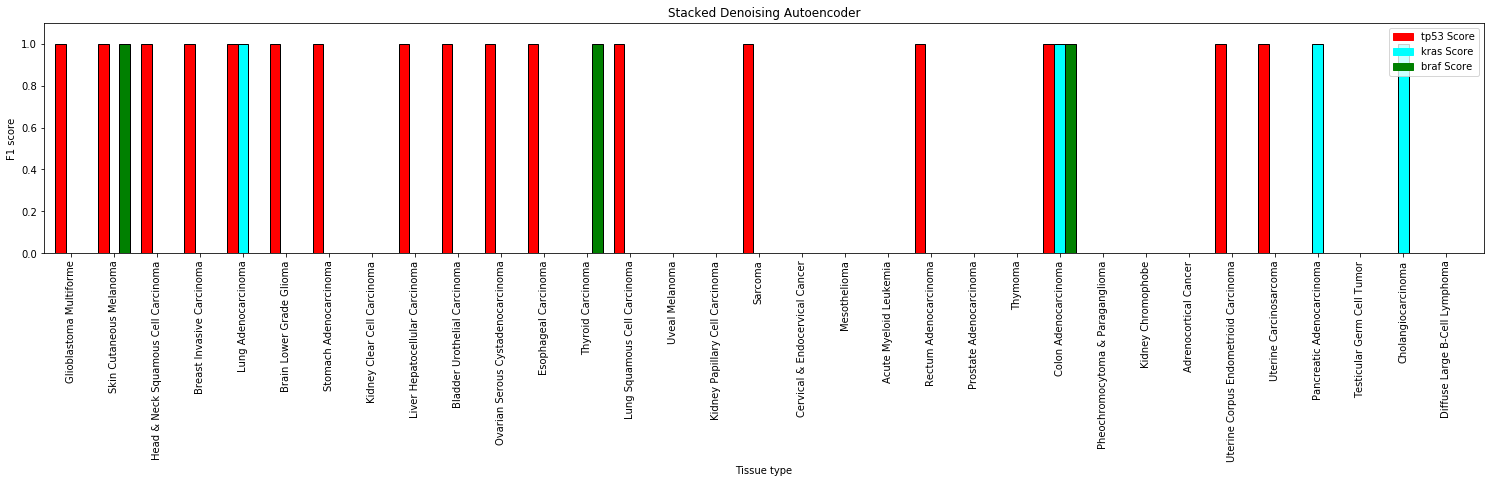

In [22]:
yPred, yActual, trainedModel = run()
plotByTissue(yPred, yActual)

## Run model on holdout set

In [23]:
holdout_pred = trainedModel.fit(X_sub_holdout)

pred0 = [v[0] for v in yPred]
pred1 =  [int(v[1]) for v in yPred]
pred2 =  [int(v[2]) for v in yPred]
pred3 =  [int(v[3]) for v in yPred]

##### Write output file
pd.DataFrame({
    "TumorTypePrediction": pred0,
    "TP53MutationPrediction": pred1,
    "KRASMutationPrediction": pred2,
    "BRAFMutationPrediction": pred3,
}).to_csv("predict.tsv", sep="\t")


AttributeError: 'StackedDenoisingAutoencoder' object has no attribute 'fit'